# **BCG X Capstone Project** 
<img src="https://web-assets.bcg.com/1a/1f/6b52570e4ba49920815bdda88e36/bcgx-meet-banner.jpg" alt="drawing" style="width:800px; height:300px"/>

### **Stock Demand - SARIMA for Demand Analysis Notebook**

**Group members**

Morten Aas-Lyngby, Paolo Brambillasca,  Ignacio Alonso Lopez-Linares, Emilio Jair Rodriguez Capitan, Alberto Dona

**Notebook description**

This notebook provides the fifth and final step in our Analysis. 
It focusses on autoreggresive, moving average and seasonality patterns and SARIMAX methods to provide better stock demand predictability. 
It will only focus on one branch (the one with highest sales), but it can be applied to every one of them.

**Problem definition**

The Team has been tasked with building a Churn Model to increase CLTV as well as to help ClienCo. in their product cross-selling strategy and demand forecasting problem

In order to give more insights to the company on the stock and sales, we wil create a SARIMA analysis deep diving in the branched and the products:

- The goal of the branch analysis is to give the big picture of the future stock levels in the specified branch.
- The goal of the product analysis is to give a detail view of the behavior of the selected product and a forecast of a selected window.

# Table of Contents

1. [Importing Necessary Libraries](#1-importing-necessary-libraries)
2. [SARIMAX Models for ClientCo Branches](#2-sarimax-models-for-clientco-branches)
   - [2.1 Introduction](#21-introduction)
   - [2.2 Weekly Analysis](#22-weekly-analysis)
   - [2.3 Monthly Analysis](#23-monthly-analysis)
3. [SARIMAX Models for ClientCo Products](#3-sarimax-models-for-clientco-products)
   - [3.1 Introduction](#31-introduction)
   - [3.2 Weekly Analysis](#32-weekly-analysis)
   - [3.3 Monthly Analysis](#33-monthly-analysis)


### **1. Importing necessary Libraries**

In [ ]:
# Import necessary libraries
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from itertools import product
from statsmodels.tsa.seasonal import seasonal_decompose
import pmdarima as pm
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


In [33]:
# Import the data
data = pd.read_parquet("data/trasactions_cleaned")


In [4]:
data.head()


,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id,sales_per_quantity,order_year,order_month,order_day_month,order_day_week,order_period,monthly_sales,customer_lifetime_value,previous_month_sales,year_and_month,days_between_orders,order_date
1972548,2017-10-27,2017-10-27,2173586,6,55.820999,5,by phone,8470,11.164200,2017,October,27,Friday,2017-10,411488192.0,5882.233001,411488192.0,2017-10,0.0,2017-10-27
1989347,2017-10-27,2017-10-27,857055,6,21.046886,401,by phone,8470,0.052486,2017,October,27,Friday,2017-10,411488192.0,5882.233001,411488192.0,2017-10,0.0,2017-10-27
2007841,2017-10-27,2017-10-27,2299248,6,20.469999,5,by phone,8470,4.094000,2017,October,27,Friday,2017-10,411488192.0,5882.233001,411488192.0,2017-10,0.0,2017-10-27
2015108,2017-10-27,2017-10-27,482165,6,8.418000,61,by phone,8470,0.138000,2017,October,27,Friday,2017-10,411488192.0,5882.233001,411488192.0,2017-10,0.0,2017-10-27
2019068,2017-10-27,2017-10-27,1437249,6,48.467072,101,by phone,8470,0.479872,2017,October,27,Friday,2017-10,411488192.0,5882.233001,411488192.0,2017-10,0.0,2017-10-27


In [5]:
data.dtypes


date_order                 datetime64[ns]
date_invoice               datetime64[ns]
product_id                          int32
client_id                           int32
sales_net                         float32
quantity                            int32
order_channel                    category
branch_id                           int16
sales_per_quantity                float32
order_year                          int16
order_month                      category
order_day_month                      int8
order_day_week                   category
order_period                    period[M]
monthly_sales                     float32
customer_lifetime_value           float64
previous_month_sales              float32
year_and_month                  period[M]
days_between_orders               float64
order_date                         object
dtype: object

In [6]:
data.drop(columns=["order_date"])


,date_order,date_invoice,product_id,client_id,sales_net,quantity,order_channel,branch_id,sales_per_quantity,order_year,order_month,order_day_month,order_day_week,order_period,monthly_sales,customer_lifetime_value,previous_month_sales,year_and_month,days_between_orders
1972548,2017-10-27,2017-10-27,2173586,6,55.820999,5,by phone,8470,11.164200,2017,October,27,Friday,2017-10,411488192.0,5882.233001,411488192.0,2017-10,0.0
1989347,2017-10-27,2017-10-27,857055,6,21.046886,401,by phone,8470,0.052486,2017,October,27,Friday,2017-10,411488192.0,5882.233001,411488192.0,2017-10,0.0
2007841,2017-10-27,2017-10-27,2299248,6,20.469999,5,by phone,8470,4.094000,2017,October,27,Friday,2017-10,411488192.0,5882.233001,411488192.0,2017-10,0.0
2015108,2017-10-27,2017-10-27,482165,6,8.418000,61,by phone,8470,0.138000,2017,October,27,Friday,2017-10,411488192.0,5882.233001,411488192.0,2017-10,0.0
2019068,2017-10-27,2017-10-27,1437249,6,48.467072,101,by phone,8470,0.479872,2017,October,27,Friday,2017-10,411488192.0,5882.233001,411488192.0,2017-10,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57829738,2019-08-09,2019-08-09,2928234,2274517,163.559433,11,at the store,10078,14.869040,2019,August,9,Friday,2019-08,483342368.0,17149.516917,483342368.0,2019-08,0.0
59498669,2019-08-29,2019-08-29,1362009,2274517,30.277201,3,at the store,10078,10.092400,2019,August,29,Thursday,2019-08,483342368.0,17149.516917,483342368.0,2019-08,20.0
59604947,2019-08-29,2019-08-29,2811481,2274517,7.544000,41,at the store,10078,0.184000,2019,August,29,Thursday,2019-08,483342368.0,17149.516917,483342368.0,2019-08,0.0
59646173,2019-08-29,2019-08-29,2756692,2274517,294.612061,41,at the store,10078,7.185660,2019,August,29,Thursday,2019-08,483342368.0,17149.516917,483342368.0,2019-08,0.0


### **2. SARIMAX Models for ClientCo Branches**


#### 2.1 Introduction

First we will create a dataset grouped for the branches so we can do the SARIMA analysis on this data.

In [43]:
# Grouping the dataset by 'date_order' and 'branch_id'
daily_branch = data.groupby(['date_order', 'branch_id']).agg({
    'quantity': 'sum',  # Sum the quantities
    'sales_net': 'sum'  # Sum the sales_net (or use another aggregation function if needed)
}).reset_index()

daily_branch_grouped = pd.DataFrame(daily_branch)

daily_branch_grouped['date_order'] = pd.to_datetime(daily_branch_grouped['date_order'])

# Filtering for positive values
daily_branch_grouped = daily_branch_grouped.query('quantity > 0 & sales_net > 0')


Now, lets get the top 5 branches to try the model and see the predictions

In [75]:
# Top 5 branches with the highest sales to try the model
# Grouping the dataset by 'date_order' and 'branch_id'
branch_sales = data.groupby(['branch_id']).agg({
    'quantity': 'sum',  # Sum the quantities
    'sales_net': 'sum'  # Sum the sales_net (or use another aggregation function if needed)
}).reset_index()

branch_sales_grouped = pd.DataFrame(branch_sales)

branch_sales_grouped.sort_values("sales_net").tail(5)


,branch_id,quantity,sales_net
360,6702,47856475,107186744.0
112,1888,102675501,109866632.0
226,4080,82101756,110708456.0
113,1894,55622914,110772368.0
185,3318,105440960,118604000.0



#### 2.2 Weekly Analysis

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[52] intercept   : AIC=2661.260, Time=3.44 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=2655.099, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=2658.489, Time=0.36 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=2656.870, Time=0.34 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=2936.351, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[52] intercept   : AIC=2657.045, Time=0.21 sec
 ARIMA(0,0,0)(0,0,1)[52] intercept   : AIC=2654.916, Time=0.20 sec
 ARIMA(0,0,0)(1,0,1)[52] intercept   : AIC=2656.916, Time=0.35 sec
 ARIMA(0,0,0)(0,0,2)[52] intercept   : AIC=2656.905, Time=1.30 sec
 ARIMA(0,0,0)(1,0,2)[52] intercept   : AIC=2658.905, Time=2.44 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=2656.985, Time=0.27 sec
 ARIMA(1,0,1)(0,0,1)[52] intercept   : AIC=2658.821, Time=0.49 sec
 ARIMA(0,0,0)(0,0,1)[52]             : AIC=inf, Time=0.40 sec

Best model:  ARIMA(0,0,0)(0,0,1)[52] intercept
Total fit time: 9.840 seconds
RMSE: 260880.

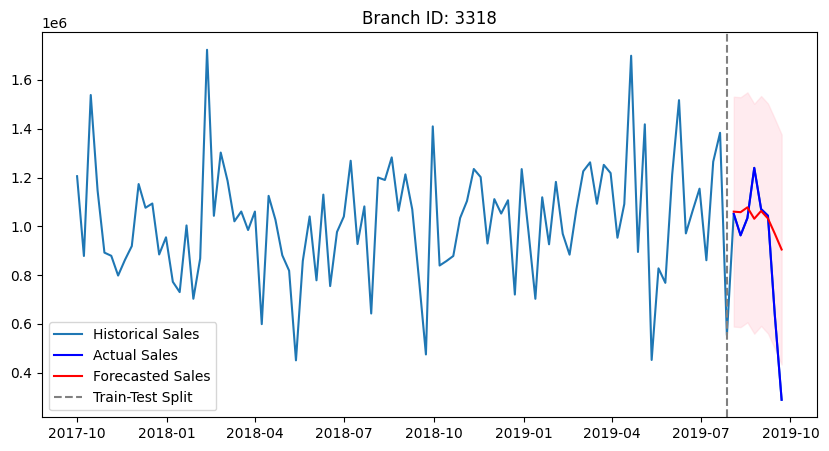

In [99]:
# Example for one branch
branch_id_example = 3318
branch_data = daily_branch_grouped[daily_branch_grouped['branch_id'] == branch_id_example]

# Set the date as the index
branch_data.set_index('date_order', inplace=True)

# Resample the data to weekly frequency, filling missing values with 0
branch_data = branch_data['quantity'].resample('W').sum().fillna(0)

# Split the data into train and test sets (e.g., last 8 weeks for testing)
train_data = branch_data[:-8]
test_data = branch_data[-8:]

# Fit a Seasonal ARIMA model on the training data
auto_model = pm.auto_arima(train_data, seasonal=True, m=52, trace=True, stepwise=True, suppress_warnings=True)

# Forecast the next 8 weeks (test period)
forecast, conf_int = auto_model.predict(n_periods=8, return_conf_int=True)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(test_data, forecast))
mae = mean_absolute_error(test_data, forecast)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

# Plot the original data, train data, test data, and the forecast
plt.figure(figsize=(10, 5))
plt.plot(branch_data.index, branch_data, label='Historical Sales')
plt.plot(test_data.index, test_data, label='Actual Sales', color='blue')
plt.plot(test_data.index, forecast, label='Forecasted Sales', color='red')
plt.fill_between(test_data.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.axvline(train_data.index[-1], color='gray', linestyle='--', label='Train-Test Split')
plt.title(f'Branch ID: {branch_id_example}')
plt.legend()
plt.show()


#### 2.3 Monthly Analysis

C:\Users\emili\AppData\Local\Temp\ipykernel_21492\1039908694.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  branch_data = branch_data['quantity'].resample('M').sum().fillna(0)
C:\Users\emili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pmdarima\arima\utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (7) is shorter than m (12). Using D=1
  warnings.warn("Appropriate D value may not have been reached; "


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=inf, Time=0.91 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=217.304, Time=0.02 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=225.419, Time=0.05 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=221.617, Time=0.06 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=221.606, Time=0.00 sec
 ARIMA(0,0,0)(1,1,0)[12] intercept   : AIC=218.787, Time=0.03 sec
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=218.660, Time=0.03 sec
 ARIMA(0,0,0)(1,1,1)[12] intercept   : AIC=218.762, Time=0.09 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=228.546, Time=0.02 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=219.788, Time=0.02 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=225.000, Time=0.05 sec

Best model:  ARIMA(0,0,0)(0,1,0)[12] intercept
Total fit time: 1.320 seconds
RMSE: 1158708.978360013
MAE: 916109.9285714285


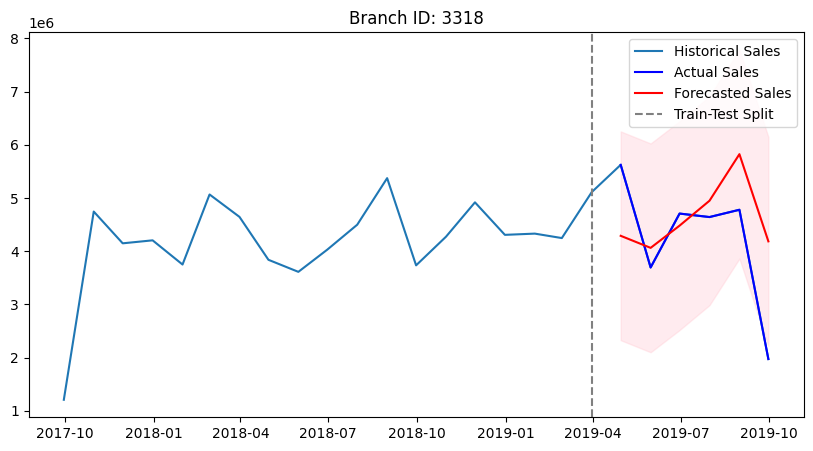

In [101]:
# Example for one branch
branch_id_example = 3318
branch_data = daily_branch_grouped[daily_branch_grouped['branch_id'] == branch_id_example]

# Set the date as the index
branch_data.set_index('date_order', inplace=True)

# Resample the data to weekly frequency, filling missing values with 0
branch_data = branch_data['quantity'].resample('M').sum().fillna(0)

# Split the data into train and test sets (e.g., last 6 months for testing)
train_data = branch_data[:-6]
test_data = branch_data[-6:]

# Fit a Seasonal ARIMA model on the training data
auto_model = pm.auto_arima(train_data, seasonal=True, m=12, trace=True, stepwise=True, suppress_warnings=True)

# Forecast the next 6 months (test period)
forecast, conf_int = auto_model.predict(n_periods=6, return_conf_int=True)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(test_data, forecast))
mae = mean_absolute_error(test_data, forecast)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

# Plot the original data, train data, test data, and the forecast
plt.figure(figsize=(10, 5))
plt.plot(branch_data.index, branch_data, label='Historical Sales')
plt.plot(test_data.index, test_data, label='Actual Sales', color='blue')
plt.plot(test_data.index, forecast, label='Forecasted Sales', color='red')
plt.fill_between(test_data.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.axvline(train_data.index[-1], color='gray', linestyle='--', label='Train-Test Split')
plt.title(f'Branch ID: {branch_id_example}')
plt.legend()
plt.show()


This model is very good trying to predict churn, taking into consideration different variables than the ones used to define it. With an F1 score of 76,99, it takes into consideration the total period a customer has been buying with the company as the most valuable variable, followed by number of tickets and total sales. This variables take into consideration both time and sales to try to predict churn.


### **3. SARIMAX Models for ClientCo Products**

#### 3.1 Introduction

In [54]:
# Grouping the dataset by 'date_order' and 'product_id'
daily_product = data.groupby(['date_order', 'product_id']).agg({
    'quantity': 'sum',  # Sum the quantities
    'sales_net': 'sum'  # Sum the sales_net (or use another aggregation function if needed)
}).reset_index()

daily_product_grouped = pd.DataFrame(daily_product)

daily_product_grouped['date_order'] = pd.to_datetime(daily_product_grouped['date_order'])

# Filtering for positive values
daily_product_grouped = daily_product_grouped.query('quantity > 0 & sales_net > 0')


In [55]:
daily_product_grouped.sort_values("sales_net")


,date_order,product_id,quantity,sales_net
11603572,2019-08-30,371291,16,2.980232e-08
11894575,2019-09-18,2511696,36,5.960464e-08
2572616,2018-02-26,1302468,212,5.960464e-08
9724929,2019-05-15,1921140,84,2.384186e-07
7601558,2018-12-28,2738685,24,2.384186e-07
...,...,...,...,...
9481286,2019-04-25,556388,30001,8.098110e+05
9482321,2019-04-25,717025,265371,8.826806e+05
2479968,2018-02-20,2333835,3866,9.593081e+05
9504241,2019-04-26,871702,312003,1.096744e+06


In [84]:
# Top 5 branches with the highest sales

# Grouping the dataset by 'date_order' and 'branch_id'
product_qty = data.groupby(['product_id']).agg({
    'quantity': 'sum',  # Sum the quantities
    'sales_net': 'sum'  # Sum the sales_net (or use another aggregation function if needed)
}).reset_index()

product_qty_grouped = pd.DataFrame(product_qty)

product_qty_grouped.sort_values("quantity").tail(5)


,product_id,quantity,sales_net
221042,1180925,56308121,8.123472e+06
174453,932375,60046988,5.513060e+06
100954,539670,67948922,4.781551e+04
86595,463156,74832250,2.415087e+07
502752,2681878,80663055,3.850502e+07



#### 3.2 Weekly Analysis

C:\Users\emili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pmdarima\arima\utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (40) is shorter than m (52). Using D=1
  warnings.warn("Appropriate D value may not have been reached; "


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[52] intercept   : AIC=inf, Time=15.46 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=1060.938, Time=0.07 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=1062.807, Time=2.42 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=1061.908, Time=1.67 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=1096.466, Time=0.05 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=1062.901, Time=1.08 sec
 ARIMA(0,0,0)(0,1,1)[52] intercept   : AIC=1062.888, Time=1.13 sec
 ARIMA(0,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=7.21 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=1060.825, Time=0.12 sec
 ARIMA(1,0,0)(0,1,1)[52] intercept   : AIC=1062.813, Time=1.57 sec
 ARIMA(1,0,0)(1,1,1)[52] intercept   : AIC=1064.118, Time=7.04 sec
 ARIMA(2,0,0)(0,1,0)[52] intercept   : AIC=1061.820, Time=0.22 sec
 ARIMA(1,0,1)(0,1,0)[52] intercept   : AIC=1061.767, Time=0.24 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=1061.153, Time=0.18 sec
 ARIMA(2,0,1)(0,1,0)[52] int

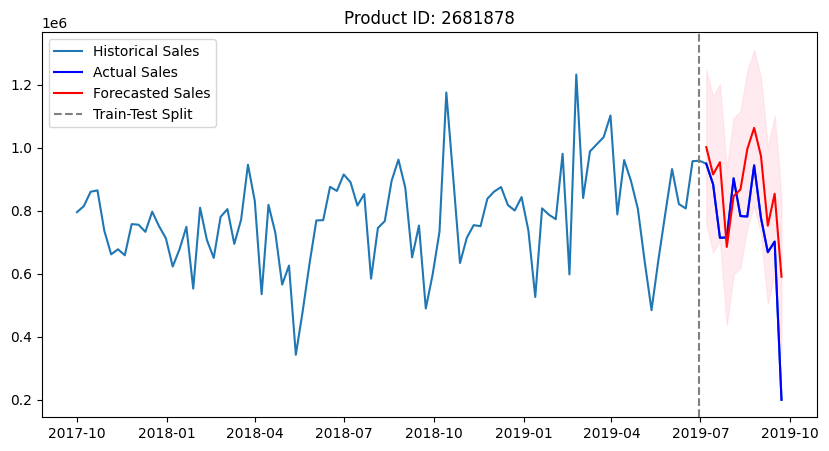

In [112]:
# Example for one product
product_id_example = 2681878
product_data = daily_product_grouped[daily_product_grouped['product_id'] == product_id_example]

# Set the date as the index
product_data.set_index('date_order', inplace=True)

# Resample the data to weekly frequency, filling missing values with 0
product_data = product_data['quantity'].resample('W').sum().fillna(0)

# Split the data into train and test sets (e.g., last 12 weeks for testing)
train_data = product_data[:-12]
test_data = product_data[-12:]

# Fit a Seasonal ARIMA model on the training data
auto_model = pm.auto_arima(train_data, seasonal=True, m=52, trace=True, stepwise=True, suppress_warnings=True)

# Forecast the next 12 weeks (test period)
forecast, conf_int = auto_model.predict(n_periods=12, return_conf_int=True)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(test_data, forecast))
mae = mean_absolute_error(test_data, forecast)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

# Plot the original data, train data, test data, and the forecast
plt.figure(figsize=(10, 5))
plt.plot(product_data.index, product_data, label='Historical Sales')
plt.plot(test_data.index, test_data, label='Actual Sales', color='blue')
plt.plot(test_data.index, forecast, label='Forecasted Sales', color='red')
plt.fill_between(test_data.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.axvline(train_data.index[-1], color='gray', linestyle='--', label='Train-Test Split')
plt.title(f'Product ID: {product_id_example}')
plt.legend()
plt.show()



#### 3.3 Monthly Analysis

C:\Users\emili\AppData\Local\Temp\ipykernel_21492\2605630205.py:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  product_data = product_data['quantity'].resample('M').sum().fillna(0)
C:\Users\emili\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\pmdarima\arima\utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (7) is shorter than m (12). Using D=1
  warnings.warn("Appropriate D value may not have been reached; "


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,1,1)[12] intercept   : AIC=212.413, Time=1.39 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=206.729, Time=0.00 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=200.600, Time=0.07 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=196.739, Time=0.05 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=216.996, Time=0.01 sec
 ARIMA(0,0,1)(0,1,0)[12] intercept   : AIC=194.748, Time=0.02 sec
 ARIMA(0,0,1)(1,1,0)[12] intercept   : AIC=196.738, Time=0.05 sec
 ARIMA(0,0,1)(1,1,1)[12] intercept   : AIC=198.679, Time=0.82 sec
 ARIMA(1,0,1)(0,1,0)[12] intercept   : AIC=inf, Time=0.09 sec
 ARIMA(0,0,2)(0,1,0)[12] intercept   : AIC=205.635, Time=0.03 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=204.726, Time=0.01 sec
 ARIMA(1,0,2)(0,1,0)[12] intercept   : AIC=206.599, Time=0.30 sec
 ARIMA(0,0,1)(0,1,0)[12]             : AIC=204.359, Time=0.02 sec

Best model:  ARIMA(0,0,1)(0,1,0)[12] intercept
Total fit time: 2.885 seconds
RMSE: 699009.1047955512
M

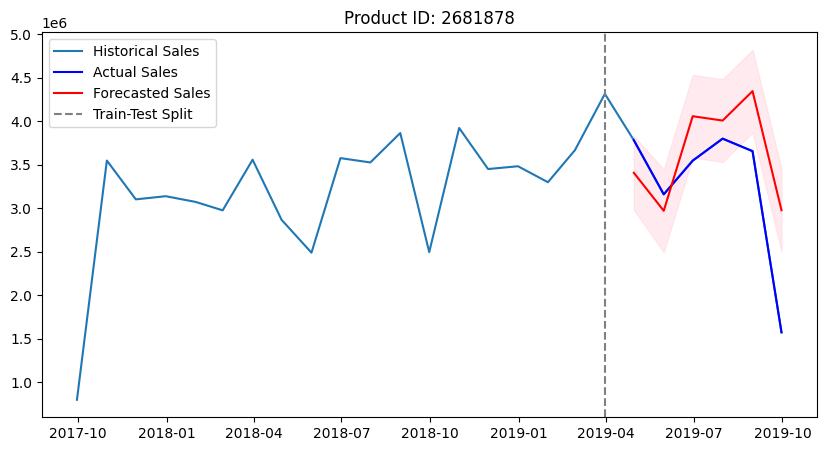

In [111]:
# Example for one product
product_id_example = 2681878
product_data = daily_product_grouped[daily_product_grouped['product_id'] == product_id_example]

# Set the date as the index
product_data.set_index('date_order', inplace=True)

# Resample the data to weekly frequency, filling missing values with 0
product_data = product_data['quantity'].resample('M').sum().fillna(0)

# Split the data into train and test sets (e.g., last 6 months for testing)
train_data = product_data[:-6]
test_data = product_data[-6:]

# Fit a Seasonal ARIMA model on the training data
auto_model = pm.auto_arima(train_data, seasonal=True, m=12, trace=True, stepwise=True, suppress_warnings=True)

# Forecast the next 6 months (test period)
forecast, conf_int = auto_model.predict(n_periods=6, return_conf_int=True)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(test_data, forecast))
mae = mean_absolute_error(test_data, forecast)

print(f'RMSE: {rmse}')
print(f'MAE: {mae}')

# Plot the original data, train data, test data, and the forecast
plt.figure(figsize=(10, 5))
plt.plot(product_data.index, product_data, label='Historical Sales')
plt.plot(test_data.index, test_data, label='Actual Sales', color='blue')
plt.plot(test_data.index, forecast, label='Forecasted Sales', color='red')
plt.fill_between(test_data.index, conf_int[:, 0], conf_int[:, 1], color='pink', alpha=0.3)
plt.axvline(train_data.index[-1], color='gray', linestyle='--', label='Train-Test Split')
plt.title(f'Product ID: {product_id_example}')
plt.legend()
plt.show()
